# Imports

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
import seaborn as sns

In [21]:
from pyspark.sql.window import Window
from pyspark.sql.functions import when, col, desc, asc, count,avg, sum, round,collect_list, lit, concat
import pyspark.sql.functions as F

# Plot theme

In [321]:
# Setting the dark theme
plt.style.use('dark_background')

# Custom forest-like colors
colors = {
    'background': '#2B3A42',  # Dark forest green
    'text': '#8EBA43',        # Light green for text
    'bars': '#1C2833',        # Darker green for bars
    'edges': '#8EBA43'        # Light green for edges
}

# Applying custom colors to Seaborn
sns.set_palette([colors['bars'], colors['edges']])


# Read data

In [1]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName('IPL-Analysis').getOrCreate()

In [242]:
matches = spark.read.csv('matches_cleaned.csv',header=True, inferSchema=True).cache()

In [5]:
matches.show(5)

+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+--------+---------+--------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|target_runs|target_overs|super_over|dls_used|  umpire1|       umpire2|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+--------+---------+--------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkat

In [8]:
deliveries = spark.read.csv('deliveries.csv', inferSchema=True, header=True).cache()

In [9]:
deliveries.show(2)

+--------+------+--------------------+--------------------+----+----+-----------+-------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+
|match_id|inning|        batting_team|        bowling_team|over|ball|     batter| bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|fielder|
+--------+------+--------------------+--------------------+----+----+-----------+-------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   1| SC Ganguly|P Kumar|BB McCullum|           0|         1|         1|    legbyes|        0|              NA|            NA|     NA|
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   2|BB McCullum|P Kumar| SC Ganguly|           0|         0|         0|       NULL|        0|              NA|            NA|     NA|
+----

# Analysis

# Match Analysis

## 1. Most Frequent Finalists and Their Average Target Scores

In [13]:
# Filter final matches and group by winner
winners_df = matches.filter(col('match_type') == 'Final')\
    .groupBy('winner')

# Count the number of final matches played and display the result
winners_df.agg(count('*').alias('final_matches_played'))\
    .orderBy(desc('final_matches_played')).show()

# Calculate average target runs and display the result
winners_df.agg(round(avg('target_runs'), 2)\
    .alias('average_target_runs')).show()

+--------------------+--------------------+
|              winner|final_matches_played|
+--------------------+--------------------+
| Chennai Super Kings|                   5|
|      Mumbai Indians|                   5|
|Kolkata Knight Ri...|                   3|
| Sunrisers Hyderabad|                   1|
|      Gujarat Titans|                   1|
|     Deccan Chargers|                   1|
|    Rajasthan Royals|                   1|
+--------------------+--------------------+

+--------------------+-------------------+
|              winner|average_target_runs|
+--------------------+-------------------+
| Sunrisers Hyderabad|              209.0|
| Chennai Super Kings|              183.6|
|      Gujarat Titans|              131.0|
|     Deccan Chargers|              144.0|
|    Rajasthan Royals|              164.0|
|Kolkata Knight Ri...|             168.33|
|      Mumbai Indians|              157.8|
+--------------------+-------------------+



C:\Users\h4has\AppData\Local\Temp\ipykernel_10848\2466627204.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


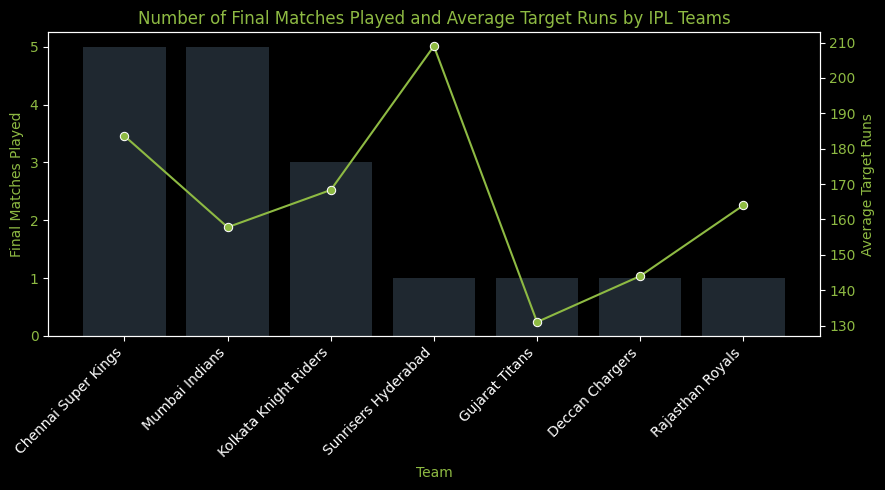

In [56]:

# Aggregating data for final matches played
data_final_matches = winners_df.agg(count('*').alias('final_matches_played'))\
    .orderBy(desc('final_matches_played'))

# Collect data into a list of rows
rows = data_final_matches.collect()
df_final_matches = pd.DataFrame(rows, columns=[col.name for col in data_final_matches.schema.fields])

# Aggregating data for average target runs
data_avg_target_runs = winners_df.agg(round(avg('target_runs'), 2).alias('average_target_runs'))
rows = data_avg_target_runs.collect()
df_avg_target_runs = pd.DataFrame(rows, columns=[col.name for col in data_avg_target_runs.schema.fields])

# Merging the two DataFrames on 'winner'
df_merged = pd.merge(df_final_matches, df_avg_target_runs, on='winner')

# Plotting
fig, ax1 = plt.subplots(figsize=(9, 5))

# First y-axis for final matches played
color = colors['bars']  # Use custom color for bars
ax1.set_xlabel('Team', color=colors['text'])
ax1.set_ylabel('Final Matches Played', color=colors['edges'])
sns.barplot(x='winner', y='final_matches_played', data=df_merged, ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=colors['edges'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Second y-axis for average target runs
ax2 = ax1.twinx()
color = colors['edges']  # Use custom color for line
ax2.set_ylabel('Average Target Runs', color=color)
sns.lineplot(x='winner', y='average_target_runs', data=df_merged, ax=ax2, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Title and grid settings
plt.title('Number of Final Matches Played and Average Target Runs by IPL Teams', color=colors['text'])
plt.grid(False)

fig.tight_layout()
plt.show()

## 2. Evaluating IPL Teams' Performance Based on Toss Decisions and First Innings Batting

###  Do Specific Teams Prefer to Bat or Field First?

In [81]:
# Pivot table on 'toss_decision' and count occurrences and calculate total tosses and batting percentage
toss_winner_df = (matches.groupBy('toss_winner')
                        .pivot('toss_decision')
                        .agg(count('*'))
                        .fillna(0)
                        .withColumn('total_tosses', col('bat') + col('field'))
                        .withColumn('batting_percentage', round((col('bat') / col('total_tosses') * 100),2))
                        .select('toss_winner', 'bat', 'field', 'total_tosses', 'batting_percentage')
                        .orderBy(desc('batting_percentage')))

In [82]:

toss_winner_df.show(truncate=False)

+---------------------------+---+-----+------------+------------------+
|toss_winner                |bat|field|total_tosses|batting_percentage|
+---------------------------+---+-----+------------+------------------+
|Deccan Chargers            |24 |19   |43          |55.81             |
|Pune Warriors              |11 |9    |20          |55.0              |
|Chennai Super Kings        |59 |62   |121         |48.76             |
|Sunrisers Hyderabad        |35 |53   |88          |39.77             |
|Kochi Tuskers Kerala       |3  |5    |8           |37.5              |
|Rajasthan Royals           |44 |74   |118         |37.29             |
|Mumbai Indians             |53 |90   |143         |37.06             |
|Lucknow Super Giants       |6  |13   |19          |31.58             |
|Kolkata Knight Riders      |38 |84   |122         |31.15             |
|Delhi Capitals             |40 |89   |129         |31.01             |
|Punjab Kings               |32 |77   |109         |29.36       

C:\Users\h4has\AppData\Local\Temp\ipykernel_10848\1164138558.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


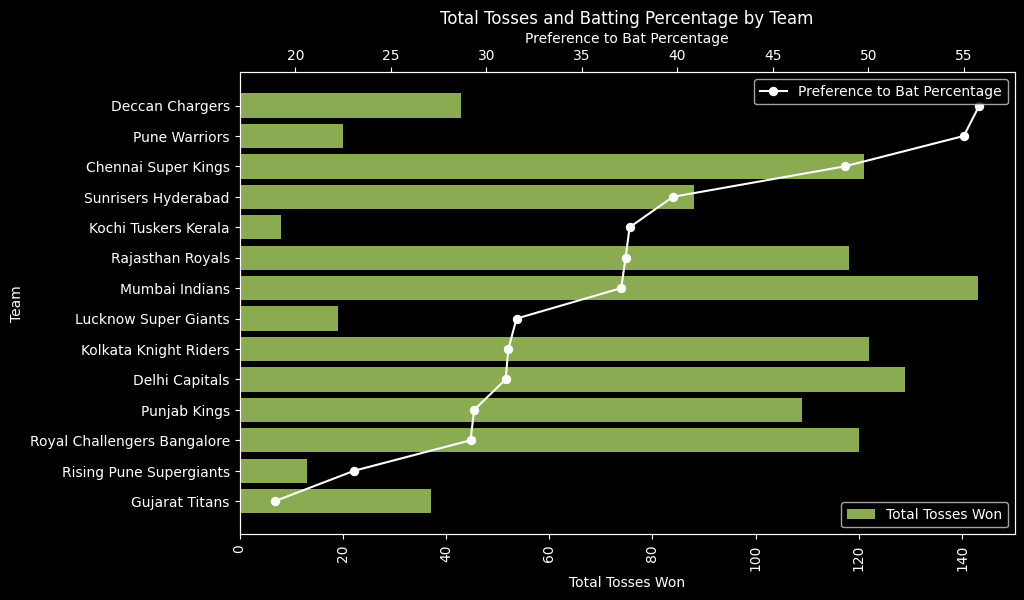

In [337]:

# Create the DataFrame
data = {
    'toss_winner': ['Deccan Chargers', 'Pune Warriors', 'Chennai Super Kings', 'Sunrisers Hyderabad', 'Kochi Tuskers Kerala', 'Rajasthan Royals', 'Mumbai Indians', 'Lucknow Super Giants', 'Kolkata Knight Riders', 'Delhi Capitals', 'Punjab Kings', 'Royal Challengers Bangalore', 'Rising Pune Supergiants', 'Gujarat Titans'],
    'bat': [24, 11, 59, 35, 3, 44, 53, 6, 38, 40, 32, 35, 3, 7],
    'field': [19, 9, 62, 53, 5, 74, 90, 13, 84, 89, 77, 85, 10, 30],
    'total_tosses': [43, 20, 121, 88, 8, 118, 143, 19, 122, 129, 109, 120, 13, 37],
    'batting_percentage': [55.81, 55.0, 48.76, 39.77, 37.5, 37.29, 37.06, 31.58, 31.15, 31.01, 29.36, 29.17, 23.08, 18.92]
}

df = pd.DataFrame(data)

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total tosses
sns.barplot(y='toss_winner', x='total_tosses', data=df, ax=ax1, color=colors['text'], label='Total Tosses Won')
ax1.set_xlabel('Total Tosses Won')
ax1.set_ylabel('Team')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.legend(loc='lower right')

# Plot batting percentage on a secondary y-axis
ax2 = ax1.twiny()
sns.lineplot(y='toss_winner', x='batting_percentage', data=df, ax=ax2, color='white', label='Preference to Bat Percentage', marker='o')
ax2.set_xlabel('Preference to Bat Percentage')
ax2.legend(loc='upper right')

plt.title('Total Tosses and Batting Percentage by Team')
plt.show()

Most teams, on winning the toss, choose to field more often and prefer to chase the target. DC and Pune are the only 2 teams that prefer to bat first.

### Is a Team More Successful as a Leader or a Chaser?

In [319]:
# Create 'played_first' column for team1 based on toss decision
# Group by team1 to get the number of times they batted first and the number of wins
# Calculate the win percentage
played_first_df = (matches.withColumn('played_first', 
                                      when(((col('toss_winner') == col('team1')) & (col('toss_decision') == 'bat')) |
                                           ((col('toss_winner') != col('team1')) & (col('toss_decision') == 'field')), 1)
                                      .otherwise(0)
                                      .cast('int'))
                          .withColumn('team1_won', when(col('team1') == col('winner'), 1).otherwise(0).cast('int'))
                          .groupBy('team1')
                          .agg(sum('played_first').alias('times_batted_first'),
                               sum('team1_won').alias('total_wins'))
                          .withColumn('win_percentage', round(col('total_wins') / col('times_batted_first') * 100,2))
                          .orderBy(desc('win_percentage')))

played_first_df.show(truncate=False)


+---------------------------+------------------+----------+--------------+
|team1                      |times_batted_first|total_wins|win_percentage|
+---------------------------+------------------+----------+--------------+
|Rising Pune Supergiants    |5                 |7         |140.0         |
|Kochi Tuskers Kerala       |3                 |3         |100.0         |
|Mumbai Indians             |89                |70        |78.65         |
|Kolkata Knight Riders      |84                |65        |77.38         |
|Rajasthan Royals           |72                |55        |76.39         |
|Chennai Super Kings        |99                |75        |75.76         |
|Lucknow Super Giants       |22                |16        |72.73         |
|Royal Challengers Bangalore|100               |70        |70.0          |
|Delhi Capitals             |90                |61        |67.78         |
|Sunrisers Hyderabad        |72                |44        |61.11         |
|Pune Warriors           

- Preferences:
Deccan Chargers and Pune Warriors prefer to bat first, and most others prefer to field first.

- High Win Percentage with High Batting:
Teams like Mumbai Indians, Kolkata Knight Riders, and Rajasthan Royals have high win percentages while also having a substantial number of games where they batted first, indicating strong performances as leaders.

- Consistent Performers:
Chennai Super Kings, Royal Challengers Bangalore, and Delhi Capitals have decent win percentages and have batted first in a significant number of games, suggesting solid performance in both leadership and chasing roles.

- Lower Win Percentages When Batted First:
Teams like Gujarat Titans and Deccan Chargers have lower win percentages when batting first, which might suggest they perform better as chasers or under different conditions.

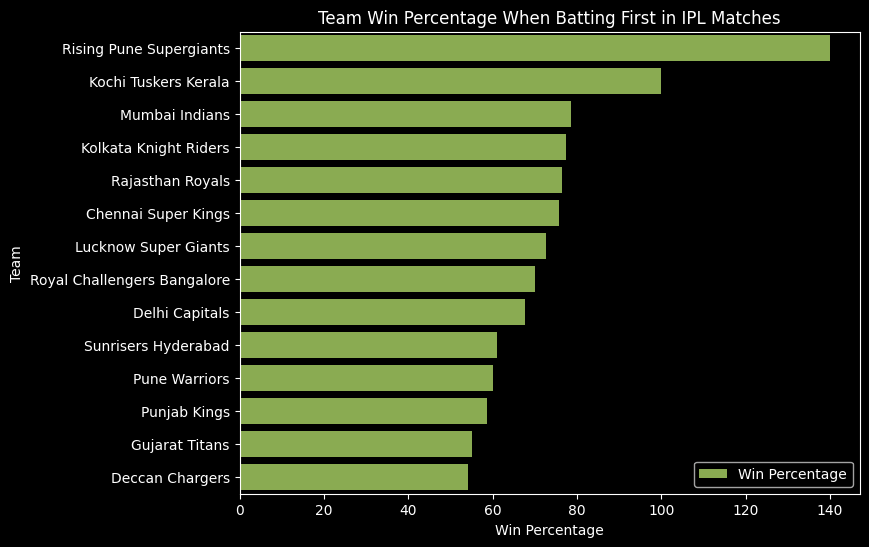

In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame
data = {
    'team1': ['Rising Pune Supergiants', 'Kochi Tuskers Kerala', 'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals', 'Chennai Super Kings', 'Lucknow Super Giants', 'Royal Challengers Bangalore', 'Delhi Capitals', 'Sunrisers Hyderabad', 'Pune Warriors', 'Punjab Kings', 'Gujarat Titans', 'Deccan Chargers'],
    'times_batted_first': [5, 3, 89, 84, 72, 99, 22, 100, 90, 72, 10, 92, 29, 24],
    'total_wins': [7, 3, 70, 65, 55, 75, 16, 70, 61, 44, 6, 54, 16, 13],
    'win_percentage': [140.0, 100.0, 78.65, 77.38, 76.39, 75.76, 72.73, 70.0, 67.78, 61.11, 60.0, 58.7, 55.17, 54.17]
}

df = pd.DataFrame(data)

# Create the horizontal bar chart
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot win percentages
sns.barplot(y='team1', x='win_percentage', data=df, ax=ax1, color=colors['text'], label='Win Percentage')
ax1.set_xlabel('Win Percentage')
ax1.set_ylabel('Team')
ax1.legend(loc='lower right')

plt.title('Team Win Percentage When Batting First in IPL Matches')
plt.show()


C:\Users\h4has\AppData\Local\Temp\ipykernel_10848\1869185873.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)


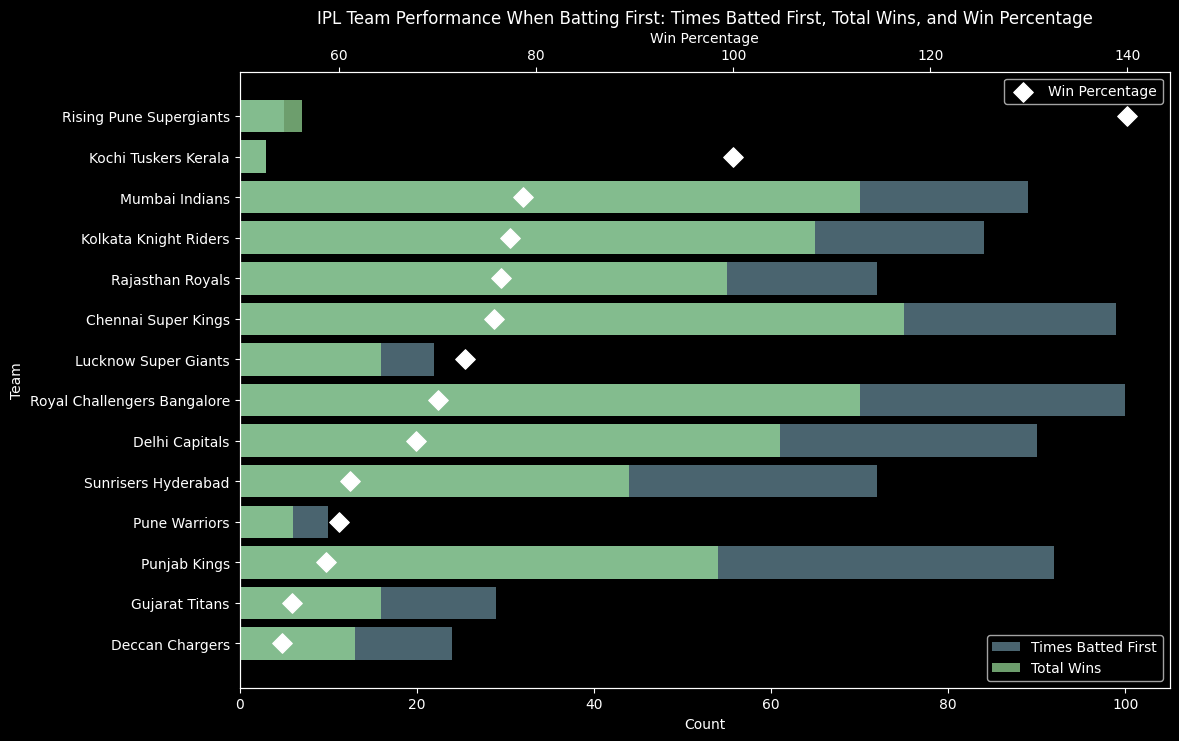

In [354]:
# Create the DataFrame
data = {
    'team1': ['Rising Pune Supergiants', 'Kochi Tuskers Kerala', 'Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals', 'Chennai Super Kings', 'Lucknow Super Giants', 'Royal Challengers Bangalore', 'Delhi Capitals', 'Sunrisers Hyderabad', 'Pune Warriors', 'Punjab Kings', 'Gujarat Titans', 'Deccan Chargers'],
    'times_batted_first': [5, 3, 89, 84, 72, 99, 22, 100, 90, 72, 10, 92, 29, 24],
    'total_wins': [7, 3, 70, 65, 55, 75, 16, 70, 61, 44, 6, 54, 16, 13],
    'win_percentage': [140.0, 100.0, 78.65, 77.38, 76.39, 75.76, 72.73, 70.0, 67.78, 61.11, 60.0, 58.7, 55.17, 54.17]
}

df = pd.DataFrame(data)

# Create the figure and the bar plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot times_batted_first
bar1 = sns.barplot(y='team1', x='times_batted_first', data=df, ax=ax1, color='skyblue', label='Times Batted First', alpha=0.5)
ax1.set_xlabel('Count')
ax1.set_ylabel('Team')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.legend(loc='lower right')

# Plot total_wins
bar2 = sns.barplot(y='team1', x='total_wins', data=df, ax=ax1, color='lightgreen', label='Total Wins', alpha=0.7)
ax1.legend(loc='lower right')

# Create a second y-axis for win_percentage
ax2 = ax1.twiny()
scatter = sns.scatterplot(y='team1', x='win_percentage', data=df, ax=ax2, color='white', label='Win Percentage', s=100, marker='D')
ax2.set_xlabel('Win Percentage')
ax2.legend(loc='upper right')

plt.title('IPL Team Performance When Batting First: Times Batted First, Total Wins, and Win Percentage')
plt.show()

## 3. The player_of_match most times won by a person

In [356]:
top_players_df = matches.groupBy('player_of_match').agg(count('*')\
    .alias('times_won')).orderBy(desc('times_won')).limit(10)
top_players_df.show()

+---------------+---------+
|player_of_match|times_won|
+---------------+---------+
| AB de Villiers|       25|
|       CH Gayle|       22|
|      RG Sharma|       19|
|      DA Warner|       18|
|        V Kohli|       18|
|       MS Dhoni|       17|
|      YK Pathan|       16|
|      SR Watson|       16|
|      RA Jadeja|       16|
|      SP Narine|       15|
+---------------+---------+



C:\Users\h4has\AppData\Local\Temp\ipykernel_10848\346489077.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='times_won', y='player_of_match', data=df, palette='viridis')


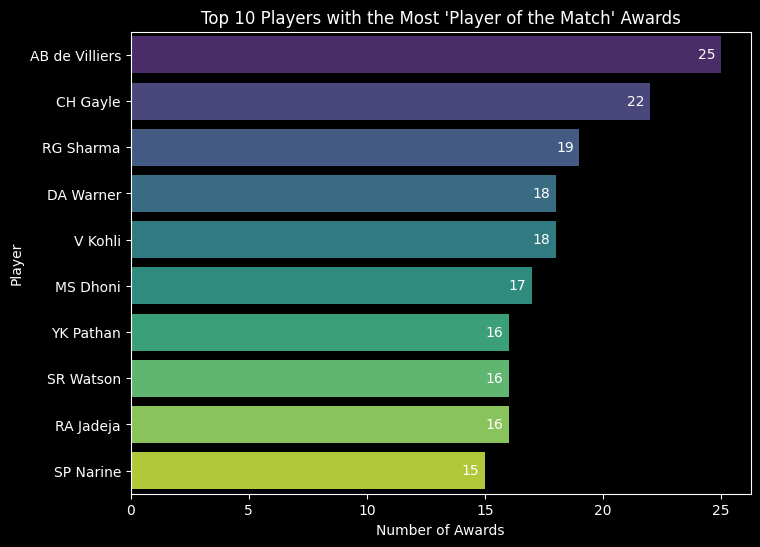

In [371]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data
data = {
    'player_of_match': ['AB de Villiers', 'CH Gayle', 'RG Sharma', 'DA Warner', 'V Kohli', 
                        'MS Dhoni', 'YK Pathan', 'SR Watson', 'RA Jadeja', 'SP Narine'],
    'times_won': [25, 22, 19, 18, 18, 17, 16, 16, 16, 15]
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='times_won', y='player_of_match', data=df, palette='viridis')
plt.title("Top 10 Players with the Most 'Player of the Match' Awards")
plt.xlabel('Number of Awards')
plt.ylabel('Player')

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width() - 1.2, p.get_y() + p.get_height() / 2),
                ha='center', va='center', 
                xytext=(10, 0), 
                textcoords='offset points',
                fontsize=10, color='white')

plt.show()


AB de Villiers has won the most Player_of_match titles, with CH Gayle and RG Sharma being second and third.

## 4. Avg target chased and Target set

In [31]:
matches.filter(col('toss_decision')=='bat').groupBy('toss_winner').agg(avg('target_runs').alias('average_target_set'))\
                            .orderBy(desc('average_target_set')).show(truncate=False)

+---------------------------+------------------+
|toss_winner                |average_target_set|
+---------------------------+------------------+
|Lucknow Super Giants       |184.16666666666666|
|Royal Challengers Bangalore|166.31428571428572|
|Chennai Super Kings        |164.66101694915255|
|Mumbai Indians             |163.96226415094338|
|Rajasthan Royals           |162.6818181818182 |
|Punjab Kings               |159.59375         |
|Gujarat Titans             |158.57142857142858|
|Deccan Chargers            |158.25            |
|Sunrisers Hyderabad        |156.9142857142857 |
|Delhi Capitals             |156.825           |
|Kolkata Knight Riders      |156.76315789473685|
|Pune Warriors              |146.27272727272728|
|Kochi Tuskers Kerala       |145.66666666666666|
|Rising Pune Supergiants    |127.66666666666667|
+---------------------------+------------------+



In [32]:
matches.filter(col('toss_decision')=='field').groupBy('toss_winner').agg(avg('target_runs').alias('average_target_chased'))\
                            .orderBy(desc('average_target_chased')).show(truncate=False)

+---------------------------+---------------------+
|toss_winner                |average_target_chased|
+---------------------------+---------------------+
|Lucknow Super Giants       |196.46153846153845   |
|Gujarat Titans             |180.93333333333334   |
|Punjab Kings               |174.83116883116884   |
|Mumbai Indians             |172.16666666666666   |
|Delhi Capitals             |169.69662921348313   |
|Royal Challengers Bangalore|169.1627906976744    |
|Pune Warriors              |166.77777777777777   |
|Rajasthan Royals           |166.56               |
|Deccan Chargers            |166.3684210526316    |
|Chennai Super Kings        |164.80645161290323   |
|Sunrisers Hyderabad        |162.81132075471697   |
|Kolkata Knight Riders      |161.5                |
|Rising Pune Supergiants    |142.8                |
|Kochi Tuskers Kerala       |137.4                |
+---------------------------+---------------------+



## 6. Are you more prone to win if you bat/ball first?

I think this is somewhat answered in the prev section. Since most teams choose to bat first and sometimes they win, the data suggests batting first leads to a win. Should check again

## 7. Won the toss AND won the match?

In [93]:
both_won_df = matches.filter(col('toss_winner')==col('winner'))\
                                    .groupby('toss_winner')\
                                    .count().orderBy(desc('count'))
both_won_df = both_won_df.withColumnRenamed('count','both_won')

toss_won_df = matches.groupBy('toss_winner').count()
toss_won_df = toss_won_df.withColumnRenamed('count','tosses_won')

toss_win_perc_df = both_won_df.join(toss_won_df,on='toss_winner')
toss_win_perc_df = toss_win_perc_df.withColumn('both_win_perc',col('both_won')/col('tosses_won')*100).orderBy(desc('match_wins_perc'))
toss_win_perc_df.show()

+--------------------+--------+----------+------------------+
|         toss_winner|both_won|tosses_won|   match_wins_perc|
+--------------------+--------+----------+------------------+
|      Gujarat Titans|      24|        37| 64.86486486486487|
|Rising Pune Super...|       8|        13| 61.53846153846154|
| Chennai Super Kings|      75|       122| 61.47540983606557|
|Kolkata Knight Ri...|      68|       122| 55.73770491803278|
|      Mumbai Indians|      78|       143| 54.54545454545454|
|Lucknow Super Giants|      10|        19| 52.63157894736842|
|Royal Challengers...|      61|       121|50.413223140495866|
|Kochi Tuskers Kerala|       4|         8|              50.0|
|    Rajasthan Royals|      60|       120|              50.0|
|      Delhi Capitals|      61|       130| 46.92307692307692|
|     Deccan Chargers|      19|        43| 44.18604651162791|
| Sunrisers Hyderabad|      38|        88| 43.18181818181818|
|        Punjab Kings|      45|       109|41.284403669724774|
|       

In [65]:
# Get count of each team in column team 1
team1_counts_df = matches.groupBy('team1').count()
team1_counts_df = team1_counts_df.withColumnRenamed('team1','team')
# Get count of each team in column team 2
team2_counts_df = matches.groupBy('team2').count()
team2_counts_df = team2_counts_df.withColumnRenamed('team2','team')

# Get total count of each team to get toal matches played
total_matches_df = team1_counts_df.union(team2_counts_df)
total_matches_df = total_matches_df.groupBy('team').\
    agg(sum(col('count')).alias('count'))\
    .orderBy(desc(col('count')))

# Total tosses won by each team
tosses_won_df = matches.groupBy('toss_winner').agg(count(col('*')).alias('tosses_won'))\
    .orderBy(desc('tosses_won'))
tosses_won_df = tosses_won_df.withColumnRenamed('toss_winner','team')

# Total matches won by each team
matches_won_df = matches.groupBy('winner').agg(count(col('*')).alias('matches_won'))\
    .orderBy(desc('matches_won'))
matches_won_df = matches_won_df.withColumnRenamed('winner','team')

# Total matches won by each team
both_won_df = matches.filter(col('toss_winner')==col('winner'))\
    .groupBy('winner').agg(count(col('*')).alias('both_won'))\
    .orderBy(desc('both_won'))
both_won_df = both_won_df.withColumnRenamed('winner','team')

total_matches_df = total_matches_df.join(tosses_won_df, on='team')\
    .join(matches_won_df,on='team')\
    .join(both_won_df,on='team').show(truncate=False)

+---------------------------+-----+----------+-----------+--------+
|team                       |count|tosses_won|matches_won|both_won|
+---------------------------+-----+----------+-----------+--------+
|Sunrisers Hyderabad        |182  |88        |88         |38      |
|Lucknow Super Giants       |44   |19        |24         |10      |
|Chennai Super Kings        |238  |122       |138        |75      |
|Gujarat Titans             |75   |37        |41         |24      |
|Deccan Chargers            |75   |43        |29         |19      |
|Kochi Tuskers Kerala       |14   |8         |6          |4       |
|Rajasthan Royals           |221  |120       |112        |60      |
|Royal Challengers Bangalore|255  |121       |123        |61      |
|Kolkata Knight Riders      |251  |122       |131        |68      |
|Rising Pune Supergiants    |30   |13        |15         |8       |
|Punjab Kings               |246  |109       |112        |45      |
|Pune Warriors              |46   |20        |12

### Optimized

1. Instead of performing multiple groupings and unions, achieve this in a single step using selectExpr and groupBy
2. orderBy to only the final result
3. Use Left Join to Handle Missing Data

In [105]:
# Try optimized aggregated groupBy 
team_df = matches.selectExpr('team1 as team').union(matches.selectExpr('team2 as team'))\
    .groupBy('team').agg(count('*').alias('total_matches'))

# Total tosses won by each team
tosses_won_df = matches.groupBy('toss_winner').agg(count(col('*')).alias('tosses_won'))\
    .withColumnRenamed('toss_winner','team')

# Total matches won by each team
matches_won_df = matches.groupBy('winner').agg(count(col('*')).alias('matches_won'))\
    .withColumnRenamed('winner','team')

# Total matches won by each team
both_won_df = matches.filter(col('toss_winner')==col('winner'))\
    .groupBy('winner').agg(count(col('*')).alias('both_won'))\
    .withColumnRenamed('winner','team')

total_matches_df = team_df.join(tosses_won_df, on='team',how='left')\
    .join(matches_won_df,on='team',how='left')\
    .join(both_won_df,on='team',how='left').fillna(0)\
    .orderBy(desc('total_matches'))
total_matches_df.show(truncate=False)


+---------------------------+-------------+----------+-----------+--------+
|team                       |total_matches|tosses_won|matches_won|both_won|
+---------------------------+-------------+----------+-----------+--------+
|Mumbai Indians             |261          |143       |144        |78      |
|Royal Challengers Bangalore|255          |121       |123        |61      |
|Delhi Capitals             |252          |130       |115        |61      |
|Kolkata Knight Riders      |251          |122       |131        |68      |
|Punjab Kings               |246          |109       |112        |45      |
|Chennai Super Kings        |238          |122       |138        |75      |
|Rajasthan Royals           |221          |120       |112        |60      |
|Sunrisers Hyderabad        |182          |88        |88         |38      |
|Gujarat Titans             |75           |37        |41         |24      |
|Deccan Chargers            |75           |43        |29         |19      |
|Pune Warrio

In [108]:
# Calcualte total win_rate
total_matches_df = total_matches_df.withColumn('total_win_rate', col('matches_won')/col('total_matches')*100)

# Calcualte toss_win_conversion_rate
total_matches_df = total_matches_df.withColumn('toss_win_conversion_rate', col('both_won')/col('tosses_won')*100)\
    .orderBy(desc(col('total_win_rate')),desc(col('toss_win_conversion_rate')))

total_matches_df.show(truncate=False)

+---------------------------+-------------+----------+-----------+--------+------------------+------------------------+
|team                       |total_matches|tosses_won|matches_won|both_won|total_win_rate    |toss_win_conversion_rate|
+---------------------------+-------------+----------+-----------+--------+------------------+------------------------+
|Chennai Super Kings        |238          |122       |138        |75      |57.98319327731093 |61.47540983606557       |
|Mumbai Indians             |261          |143       |144        |78      |55.172413793103445|54.54545454545454       |
|Gujarat Titans             |75           |37        |41         |24      |54.666666666666664|64.86486486486487       |
|Lucknow Super Giants       |44           |19        |24         |10      |54.54545454545454 |52.63157894736842       |
|Kolkata Knight Riders      |251          |122       |131        |68      |52.191235059760956|55.73770491803278       |
|Rajasthan Royals           |221        

Insights from the Results:
- Chennai Super Kings stand out with a 58.0% win rate across all their matches and a 61.5% success rate when they win the toss. This suggests that they perform exceptionally well overall and are very effective at converting toss wins into match victories.

- Mumbai Indians have a 55.2% win rate and a 54.5% conversion rate of toss wins into match wins. This means they not only have a strong overall performance but also excel at turning toss wins into victories, particularly among teams with a high number of matches.

- Gujarat Titans have a 54.7% win rate and a high 64.9% conversion rate when they win the toss. This indicates that they are very good at converting toss wins into match wins, although their total number of matches is lower compared to the top teams.

- Pune Warriors have the lowest performance with only a 26.1% win rate and a 15.0% conversion rate from toss wins. This shows that they struggle both in overall match performance and in making the most out of winning the toss.

## 8. Lucky venues for teams

In [106]:
team_name = 'Chennai Super Kings' #'Kolkata Knight Riders' #'Mumbai Indians'

In [107]:
matches.filter((col('team1')==team_name) | (col('team2')==team_name)).groupBy('venue').count()\
.orderBy(desc('count')).show()


+--------------------+-----+
|               venue|count|
+--------------------+-----+
|MA Chidambaram St...|   47|
|MA Chidambaram St...|   15|
|Dubai Internation...|   14|
|    Wankhede Stadium|   14|
|        Eden Gardens|   11|
|Wankhede Stadium,...|   11|
|MA Chidambaram St...|    9|
|M Chinnaswamy Sta...|    7|
|Maharashtra Crick...|    6|
|    Feroz Shah Kotla|    6|
|Sheikh Zayed Stadium|    6|
|Sharjah Cricket S...|    6|
|Sawai Mansingh St...|    6|
|JSCA Internationa...|    5|
|Dr DY Patil Sport...|    4|
|Punjab Cricket As...|    4|
|Brabourne Stadium...|    4|
|Dr DY Patil Sport...|    4|
|           Kingsmead|    4|
|Rajiv Gandhi Inte...|    3|
+--------------------+-----+
only showing top 20 rows



In [94]:
# Calculate the most successful venue for each winner
venues_df = matches.groupBy('winner', 'venue').count().dropna()

# Define window specification
windowSpec = Window.partitionBy('winner').orderBy(F.desc('count'))

# Compute dense rank and filter the top venue for each winner
top_venues_df = (venues_df
                 .withColumn('dense_rank', F.dense_rank().over(windowSpec))
                 .filter(F.col('dense_rank') == 1)
                 .select('winner', 'venue', 'count'))

top_venues_df.orderBy(F.desc('count')).show(truncate=False)

+---------------------------+---------------------------------------------------------------------+-----+
|winner                     |venue                                                                |count|
+---------------------------+---------------------------------------------------------------------+-----+
|Kolkata Knight Riders      |Eden Gardens                                                         |45   |
|Mumbai Indians             |Wankhede Stadium                                                     |42   |
|Chennai Super Kings        |MA Chidambaram Stadium, Chepauk                                      |33   |
|Rajasthan Royals           |Sawai Mansingh Stadium                                               |32   |
|Royal Challengers Bangalore|M Chinnaswamy Stadium                                                |29   |
|Delhi Capitals             |Feroz Shah Kotla                                                     |23   |
|Sunrisers Hyderabad        |Rajiv Gandhi Inte

In [124]:
venues_df = matches.groupBy('winner','venue').count().orderBy('winner').dropna()
venues_df.show(3)

+-------------------+--------------------+-----+
|             winner|               venue|count|
+-------------------+--------------------+-----+
|Chennai Super Kings|Rajiv Gandhi Inte...|    2|
|Chennai Super Kings|Sheikh Zayed Stadium|    3|
|Chennai Super Kings|Rajiv Gandhi Inte...|    1|
+-------------------+--------------------+-----+
only showing top 3 rows



In [125]:
windowSpec = Window.partitionBy('winner').orderBy(desc(col('count')))


In [126]:
venues_df.withColumn('dense_rank', F.dense_rank().over(windowSpec))\
    .filter(col('dense_rank')==1)\
    .select('winner','venue','count').show(truncate=False)

+---------------------------+---------------------------------------------------------------------+-----+
|winner                     |venue                                                                |count|
+---------------------------+---------------------------------------------------------------------+-----+
|Chennai Super Kings        |MA Chidambaram Stadium, Chepauk                                      |33   |
|Deccan Chargers            |Rajiv Gandhi International Stadium, Uppal                            |3    |
|Deccan Chargers            |Barabati Stadium                                                     |3    |
|Delhi Capitals             |Feroz Shah Kotla                                                     |23   |
|Gujarat Titans             |Narendra Modi Stadium, Ahmedabad                                     |9    |
|Kochi Tuskers Kerala       |Nehru Stadium                                                        |2    |
|Kolkata Knight Riders      |Eden Gardens     

# Deliveries Analysis

## 1. get team wise - avg over where most wickets took place

In [130]:
# filter is_wicket deliveries and group by batting team
deliveries.filter(col('is_wicket')==1)\
    .groupBy('batting_team').agg(round(avg('over'),2).alias('avg_wicket_over'))\
    .orderBy('avg_wicket_over').show()

+--------------------+---------------+
|        batting_team|avg_wicket_over|
+--------------------+---------------+
|    Delhi Daredevils|          10.32|
|Kolkata Knight Ri...|          10.76|
|      Delhi Capitals|          10.81|
|Lucknow Super Giants|          10.85|
|       Gujarat Lions|          10.89|
|Royal Challengers...|          10.94|
|        Punjab Kings|          10.95|
| Chennai Super Kings|          10.98|
|     Kings XI Punjab|          10.99|
|Kochi Tuskers Kerala|          11.03|
|       Pune Warriors|          11.09|
|    Rajasthan Royals|          11.12|
|      Gujarat Titans|          11.15|
|      Mumbai Indians|          11.22|
|Rising Pune Super...|          11.23|
| Sunrisers Hyderabad|          11.43|
|Rising Pune Super...|          11.62|
|     Deccan Chargers|          11.63|
|Royal Challengers...|          11.75|
+--------------------+---------------+



In [131]:
# filter is_wicket deliveries and group by batting team
deliveries.filter(col('is_wicket')==1)\
    .groupBy('batting_team').agg(round(avg('ball'),2).alias('avg_wicket_ball'))\
    .orderBy('avg_wicket_ball').show()

+--------------------+---------------+
|        batting_team|avg_wicket_ball|
+--------------------+---------------+
|Rising Pune Super...|            3.4|
|    Rajasthan Royals|           3.53|
|     Deccan Chargers|           3.55|
|      Gujarat Titans|            3.6|
|      Delhi Capitals|           3.61|
| Chennai Super Kings|           3.63|
|       Pune Warriors|           3.63|
|Rising Pune Super...|           3.63|
|      Mumbai Indians|           3.64|
|Kolkata Knight Ri...|           3.66|
|Royal Challengers...|           3.69|
|    Delhi Daredevils|            3.7|
|Kochi Tuskers Kerala|           3.71|
|     Kings XI Punjab|           3.72|
|       Gujarat Lions|           3.73|
|        Punjab Kings|           3.74|
|Lucknow Super Giants|           3.74|
| Sunrisers Hyderabad|           3.75|
|Royal Challengers...|           4.15|
+--------------------+---------------+



## 2. Which ball/over does a certain batsman usually get out at?

Output too large -- not really useful

In [132]:
# filter is_wicket deliveries and group by batting team
deliveries.filter((col('is_wicket')==1) & (col('batting_team')=='Mumbai Indians'))\
    .groupBy('batter').avg('over')\
    .show(5,truncate=False)

+----------+------------------+
|batter    |avg(over)         |
+----------+------------------+
|KA Pollard|14.992248062015504|
|DR Smith  |9.473684210526315 |
|GR Napier |15.0              |
|STR Binny |19.0              |
|C Nanda   |19.0              |
+----------+------------------+
only showing top 5 rows



## 3. Which over does a batsman usually perform the best at?

Can possibly create a graph from this

In [133]:
# Group by batsman and calculate average runs per over
batter_performance_df = (deliveries.groupBy('batter')
    .pivot('over')
    .agg(F.round(F.avg('batsman_runs'), 2))
    .fillna(0))

In [125]:
batter_performance_df.orderBy('batter').show(5)

+--------------+----+----+----+----+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+----+
|        batter|   0|   1|   2|   3|   4|   5|   6|   7|   8|   9|  10| 11| 12|  13|  14|  15|  16|  17|  18|  19|
+--------------+----+----+----+----+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+----+
|A Ashish Reddy| 0.0| 0.0| 0.0| 0.0| 0.0| 1.0| 0.0| 0.0| 0.0| 0.0| 0.0|1.0|1.0|1.47|1.81|1.16|0.97|1.45|1.79|1.73|
|      A Badoni| 0.0|0.17|0.33|0.75|0.33|0.67|1.22|1.21|0.79|1.07|0.65|1.0|0.9|1.24|1.69|1.07|1.49|1.43|1.64|1.72|
|    A Chandila| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0|0.0|0.0| 0.0| 0.0| 0.0| 1.0| 0.5| 1.0|0.33|
|      A Chopra|0.25|0.88| 0.5|0.17|1.25| 1.0| 0.5|0.57|0.57| 1.3|0.33|0.0|0.0| 0.0| 1.0| 0.5| 0.0| 0.0| 0.0| 0.0|
|   A Choudhary| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0| 0.0|0.0|0.0| 0.0| 0.0| 1.0| 1.0|0.75|1.25| 2.0|
+--------------+----+----+----+----+----+----+----+----+----+----+----+---+---+-

In [126]:
top_players_df = matches.groupBy('player_of_match').agg(count('*')\
    .alias('times_won')).orderBy(desc('times_won')).limit(10)\
    .withColumnRenamed('player_of_match','batter')
top_players_df.show()

+--------------+---------+
|        batter|times_won|
+--------------+---------+
|AB de Villiers|       25|
|      CH Gayle|       22|
|     RG Sharma|       19|
|     DA Warner|       18|
|       V Kohli|       18|
|      MS Dhoni|       17|
|     YK Pathan|       16|
|     SR Watson|       16|
|     RA Jadeja|       16|
|     SP Narine|       15|
+--------------+---------+



In [127]:
# Extract top players into a list
top_players_list = [row.batter for row in top_players_df.select('batter').collect()]

# Filter the performance DataFrame to include only top players
batter_performance_top_players_df = batter_performance_df.filter(col('batter').isin(top_players_list))

# Show the result
batter_performance_top_players_df.show()


+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|        batter|   0|   1|   2|   3|   4|   5|   6|   7|   8|   9|  10|  11|  12|  13|  14|  15|  16|  17|  18|  19|
+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|     YK Pathan| 2.5|1.36|1.41|1.13|1.24|1.45|1.33|1.23|1.16|1.13|1.23|1.52|1.47|1.35|1.14|1.37|1.69|1.57|1.69|1.32|
|     RG Sharma|0.99|1.07|1.23|1.35|1.38|1.17|1.03|0.96|1.09|1.08|1.24|1.29|1.19|1.42|1.46|1.39|1.63|1.74|1.95|2.62|
|     SP Narine|1.24|1.51|1.67| 2.1|1.88|1.77|1.15|1.73|1.35|1.61|1.68|2.14| 0.6| 1.5|1.77|2.17| 1.0|1.21|0.88|0.72|
|AB de Villiers|1.64| 1.0|0.81| 1.1|1.28|1.25|1.11|1.11|1.17|1.28|1.27|1.33|1.34|1.41|1.58|1.93|1.84|2.31|2.56|2.47|
|      CH Gayle|0.89|1.06|1.48|1.57|1.64|1.42|1.23|1.53|1.46| 1.1|1.45|1.52|1.86|1.77|1.79|1.86|1.65|2.28|2.03|1.83|
|     SR Watson|0.88|0.84| 1.1|1.27|1.18|1.42|1.26|1.26|1.52| 1.

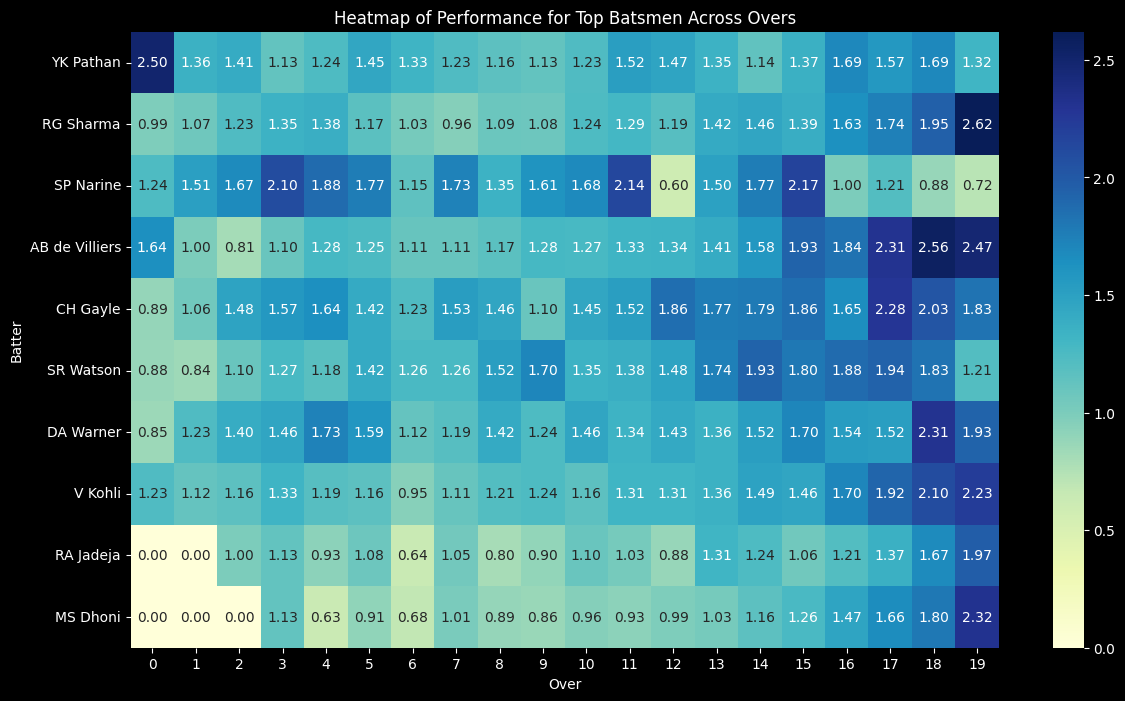

In [132]:
# Collect data into a list of rows
rows = batter_performance_top_players_df.collect()

# Convert to Pandas DataFrame
batter_performance_pd = pd.DataFrame(rows, columns=[col.name for col in batter_performance_top_players_df.schema.fields])

# Set 'batter' as index for easier plotting
batter_performance_pd.set_index('batter', inplace=True)

plt.figure(figsize=(14, 8))
sns.heatmap(batter_performance_pd, cmap='YlGnBu', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Over')
plt.ylabel('Batter')
plt.title('Heatmap of Performance for Top Batsmen Across Overs')
plt.show()

In [134]:
batter_performance_df.select('batter').distinct().count()

673

## 4. Bowlers vs. Batsmen: Uncovering the Toughest Matchups in IPL 

In [389]:
# Filter out deliveries where a wicket was taken and group by batsman and bowler
total_wicket_df = (deliveries.filter(F.col('is_wicket') == 1)
    .groupBy('batter', 'bowler')
    .agg(F.sum('is_wicket').alias('total_wickets'))
    .orderBy(F.desc('total_wickets')))

# Define a window specification to rank bowlers by the number of wickets taken for each batsman
windowSpec = Window.partitionBy('batter').orderBy(F.desc('total_wickets'))

# Assign dense rank within each partition and filter for the top-ranked bowlers for each batsman
total_wicket_df = (total_wicket_df.withColumn('denseRank', F.dense_rank().over(windowSpec))
    .filter(F.col('denseRank') == 1)
    .orderBy(F.desc('total_wickets'))
    .limit(30)
    .drop('denseRank'))

# Show the result
total_wicket_df.show(30)

+---------------+---------------+-------------+
|         batter|         bowler|total_wickets|
+---------------+---------------+-------------+
|      RG Sharma|      SP Narine|            9|
|      AM Rahane|        B Kumar|            7|
|      AT Rayudu|      MM Sharma|            7|
|       MS Dhoni|        PP Ojha|            7|
|       MS Dhoni|         Z Khan|            7|
|       PA Patel|        B Kumar|            7|
|        RR Pant|      JJ Bumrah|            7|
|     RV Uthappa|       R Ashwin|            7|
|        V Kohli| Sandeep Sharma|            7|
|      G Gambhir|         Z Khan|            6|
|     GJ Maxwell|      RA Jadeja|            6|
|     MA Agarwal|      YS Chahal|            6|
|         N Rana|      YS Chahal|            6|
|        PP Shaw|      DL Chahar|            6|
|      Q de Kock|      YS Chahal|            6|
|      SR Watson|       A Mishra|            6|
|      SR Watson|       AR Patel|            6|
|       CH Gayle|       R Ashwin|       

In [405]:
rows = total_wicket_df.limit(10).collect()
total_wickets_pd = pd.DataFrame(rows, columns=[col.name for col in total_wicket_df.schema.fields])


<Figure size 1200x1000 with 0 Axes>

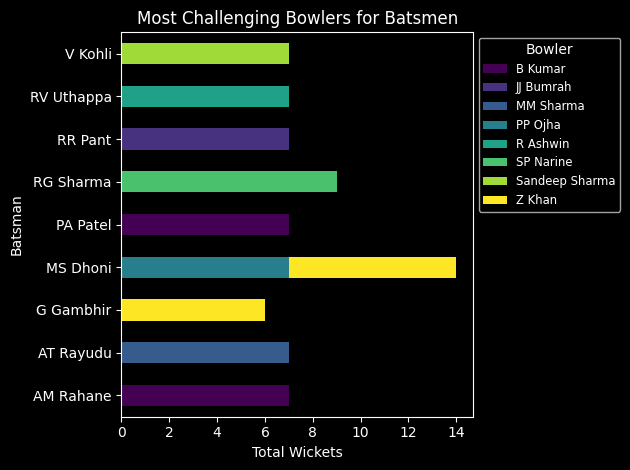

In [406]:
import matplotlib.pyplot as plt

# Pivot the DataFrame
pivot_df = total_wickets_pd.pivot(index='batter', columns='bowler', values='total_wickets').fillna(0)

# Plot
plt.figure(figsize=(12, 10))  # Adjust the size to make it more compact
ax = pivot_df.plot(
    kind='barh', 
    stacked=True, 
    colormap='viridis'
)

# Set the title and labels
plt.title('Most Challenging Bowlers for Batsmen')
plt.xlabel('Total Wickets')
plt.ylabel('Batsman')

# Adjust legend position to top right inside the plot area
plt.legend(title='Bowler', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()


<Figure size 1200x600 with 0 Axes>

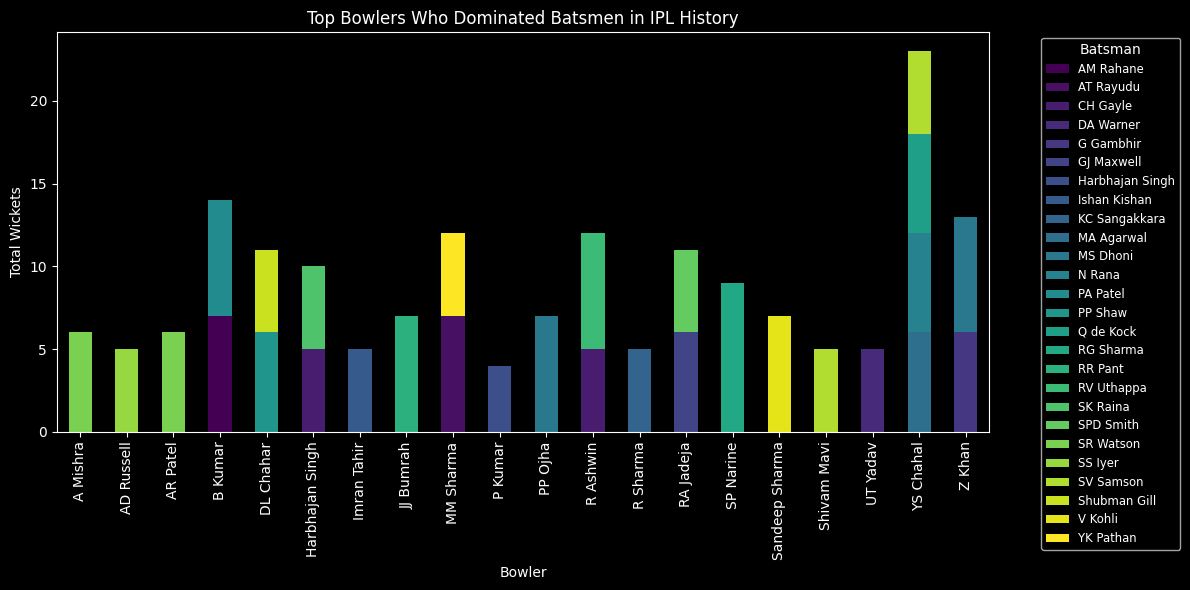

In [393]:
import matplotlib.pyplot as plt

# Pivot the DataFrame
pivot_df = total_wickets_pd.pivot(index='bowler', columns='batter', values='total_wickets').fillna(0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))  # Adjust size for compactness
ax = pivot_df.plot(
    kind='bar', 
    stacked=True, 
    colormap='viridis',
    figsize=(12, 6)  # Ensure this matches plt.figure
)

# Set the title and labels
plt.title('Top Bowlers Who Dominated Batsmen in IPL History')
plt.xlabel('Bowler')
plt.ylabel('Total Wickets')

# Adjust legend position to be inside the plot area
plt.legend(title='Batsman', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to fit everything in the figure
plt.tight_layout()

# Show the plot
plt.show()


## 5. best partnerships

In [254]:
# Insert a partnership column using least and greatest method such that the ordering of batter and non-striker does not matter
partnership_df = deliveries.withColumn('partnership', 
                   F.concat_ws(',',
                               F.least(col('batter'), col('non_striker')),
                                F.greatest(col('batter'), col('non_striker'))))
partnership_df.groupBy('partnership').count().show()

+--------------------+-----+
|         partnership|count|
+--------------------+-----+
|J Arunkumar,MV Bo...|    9|
| TL Suman,WPUJC Vaas|   19|
|  FY Fazal,SR Watson|   54|
| J Arunkumar,V Kohli|   16|
|      PR Shah,Z Khan|    3|
|   DP Nannes,S Ladda|   19|
|  BJ Hodge,LR Shukla|   36|
|R Vinay Kumar,RV ...|   27|
|   DT Patil,R Dravid|   23|
|K Goel,LA Pomersbach|   17|
| AT Rayudu,R Sathish|   14|
|BB McCullum,RT Po...|   43|
|G Gambhir,KD Karthik|  120|
|  M Kaif,SA Asnodkar|   43|
|    DB Das,DJ Hussey|   24|
|DB Ravi Teja,DNT ...|    2|
| CH Gayle,SC Ganguly|  321|
|  KP Appanna,P Kumar|    5|
|KC Sangakkara,S S...|  180|
|  AB Agarkar,WP Saha|   45|
+--------------------+-----+
only showing top 20 rows



In [238]:
partnership_df = deliveries.groupBy('batter','non_striker').sum('total_runs').orderBy('batter')
partnership_df.show()

+--------------+---------------+---------------+
|        batter|    non_striker|sum(total_runs)|
+--------------+---------------+---------------+
|A Ashish Reddy|       A Mishra|             19|
|A Ashish Reddy|    NLTC Perera|             27|
|A Ashish Reddy|       DW Steyn|              0|
|A Ashish Reddy|       J Theron|              9|
|A Ashish Reddy|       PA Patel|             21|
|A Ashish Reddy|AA Jhunjhunwala|              3|
|A Ashish Reddy|   DB Ravi Teja|              6|
|A Ashish Reddy|      JP Duminy|             10|
|A Ashish Reddy|      GH Vihari|             15|
|A Ashish Reddy|   DT Christian|              3|
|A Ashish Reddy|   MC Henriques|             11|
|A Ashish Reddy|      KV Sharma|             55|
|A Ashish Reddy|       CL White|              3|
|A Ashish Reddy|      DJG Sammy|             26|
|A Ashish Reddy|       S Dhawan|             24|
|A Ashish Reddy|     EJG Morgan|             42|
|A Ashish Reddy|      RS Bopara|             14|
|      A Badoni|    

In [240]:
partnership_df.filter(col('batter')=='A Mishra').show()

+--------+--------------+---------------+
|  batter|   non_striker|sum(total_runs)|
+--------+--------------+---------------+
|A Mishra|   AB McDonald|             13|
|A Mishra|PD Collingwood|              5|
|A Mishra|       Y Nagar|              0|
|A Mishra|      R Bhatia|              1|
|A Mishra|    KD Karthik|             15|
|A Mishra|   MF Maharoof|             26|
|A Mishra|    PJ Sangwan|              1|
|A Mishra|       A Nehra|             15|
|A Mishra|    DL Vettori|              4|
|A Mishra|    TM Dilshan|             12|
|A Mishra|     VY Mahesh|              2|
|A Mishra|      M Manhas|             15|
|A Mishra|  DT Christian|              0|
|A Mishra|  DB Ravi Teja|              2|
|A Mishra|      B Chipli|             17|
|A Mishra|      J Theron|              8|
|A Mishra|      S Dhawan|             36|
|A Mishra|      DW Steyn|             33|
|A Mishra|      CL White|              0|
|A Mishra|     KV Sharma|              7|
+--------+--------------+---------

## 6. IPL Bowlers and Their Extra Contributions: Highest Average Extra Runs Per Match

In [161]:
# Calculate total extras and average extras per match for each bowler
extras_df = deliveries.filter(F.col('extra_runs') != 0)\
    .groupBy('bowler')\
    .agg(
        F.sum('extra_runs').alias('extras'),
        F.countDistinct('match_id').alias('total_matches')
    )\
    .withColumn('avg_extras_per_match', F.col('extras') / F.col('total_matches'))

# Get top 10 bowlers with the highest average extras per match
top_extras_df = extras_df.orderBy(F.desc('avg_extras_per_match')).limit(10)

# Show the result
top_extras_df.show(truncate=False)

+------------+------+-------------+--------------------+
|bowler      |extras|total_matches|avg_extras_per_match|
+------------+------+-------------+--------------------+
|S Joseph    |14    |1            |14.0                |
|LB Williams |13    |2            |6.5                 |
|AUK Pathan  |6     |1            |6.0                 |
|AA Noffke   |6     |1            |6.0                 |
|M Siddharth |6     |1            |6.0                 |
|Abdur Razzak|6     |1            |6.0                 |
|SW Tait     |111   |20           |5.55                |
|Umar Gul    |32    |6            |5.333333333333333   |
|IC Porel    |5     |1            |5.0                 |
|H Sharma    |5     |1            |5.0                 |
+------------+------+-------------+--------------------+



- S Joseph has the highest average extras per match with an average of 14.0 extras in a single match
- SW Tait stands out with a significant number of matches (20) and a high average extras per match of 5.55, indicating a consistent trend over multiple games.


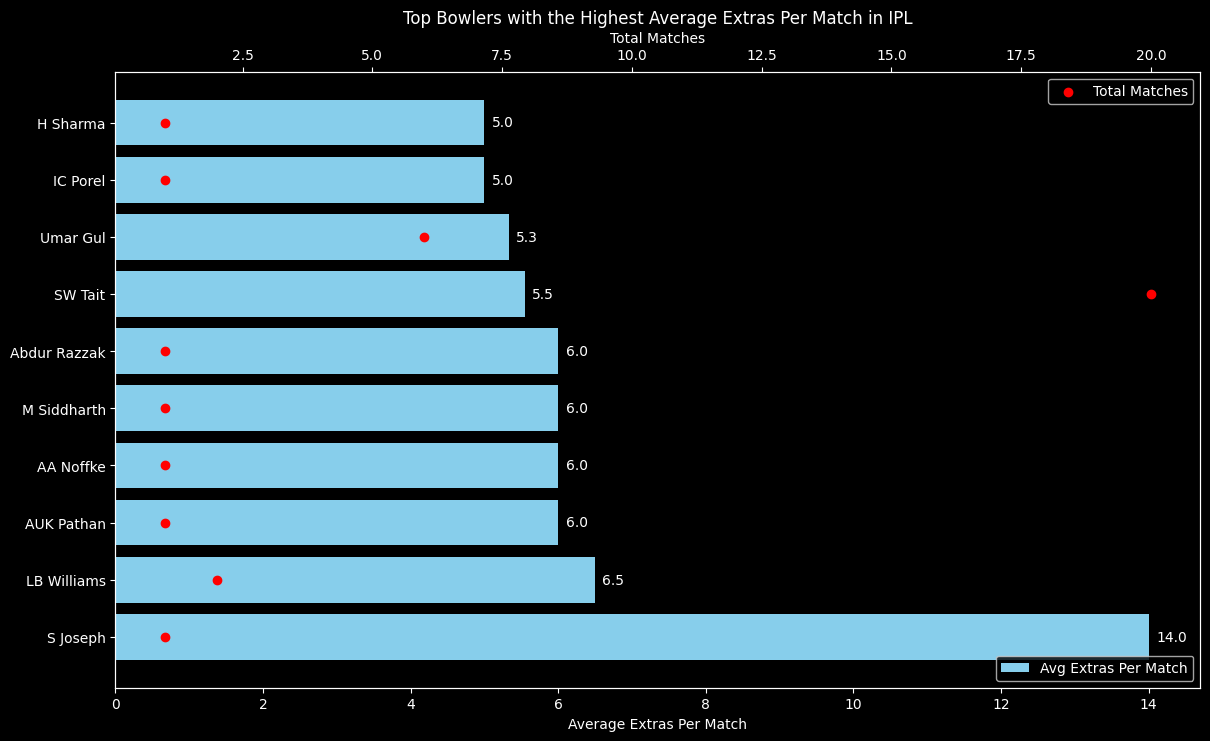

In [419]:
# Convert to Pandas DataFrame
rows = top_extras_df.collect()
extras_pd = pd.DataFrame(rows, columns=[col.name for col in top_extras_df.schema.fields])

# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for average extras per match
bars = ax1.barh(extras_pd['bowler'], extras_pd['avg_extras_per_match'], color='skyblue', label='Avg Extras Per Match')
ax1.set_xlabel('Average Extras Per Match')
ax1.set_title('Top Bowlers with the Highest Average Extras Per Match in IPL')

# Adding values on the bars
for bar in bars:
    ax1.text(bar.get_width()+0.1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}', va='center')

# Scatter plot for total matches
ax2 = ax1.twiny()
ax2.scatter(extras_pd['total_matches'], extras_pd['bowler'], color='red', label='Total Matches')
ax2.set_xlabel('Total Matches')

# Customizing grid and legend
# ax1.grid(True, axis='x')
ax2.grid(False)
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

plt.show()

## 7. Top IPL Bowlers: Total Wickets and Average Wickets Per Match

In [192]:
# Filter and aggregate wickets data
wickets_df = deliveries.filter(col('is_wicket') == 1) \
    .groupBy('bowler') \
    .agg(
        F.sum('is_wicket').alias('wickets'),
        F.countDistinct('match_id').alias('total_matches')
    ) \
    .withColumn('avg_wickets_per_match', F.round(col('wickets') / col('total_matches'), 2))

# Order by total wickets and average wickets per match, then show top 10
wickets_df = wickets_df.orderBy(
    F.desc('wickets'),
    F.desc('avg_wickets_per_match')
).limit(10)

wickets_df.show()

+----------+-------+-------------+---------------------+
|    bowler|wickets|total_matches|avg_wickets_per_match|
+----------+-------+-------------+---------------------+
| YS Chahal|    213|          122|                 1.75|
|  DJ Bravo|    207|          118|                 1.75|
| PP Chawla|    201|          128|                 1.57|
| SP Narine|    200|          119|                 1.68|
|  R Ashwin|    198|          132|                  1.5|
|   B Kumar|    195|          115|                  1.7|
|SL Malinga|    188|           94|                  2.0|
|  A Mishra|    183|          107|                 1.71|
| JJ Bumrah|    182|           90|                 2.02|
| RA Jadeja|    169|          101|                 1.67|
+----------+-------+-------------+---------------------+



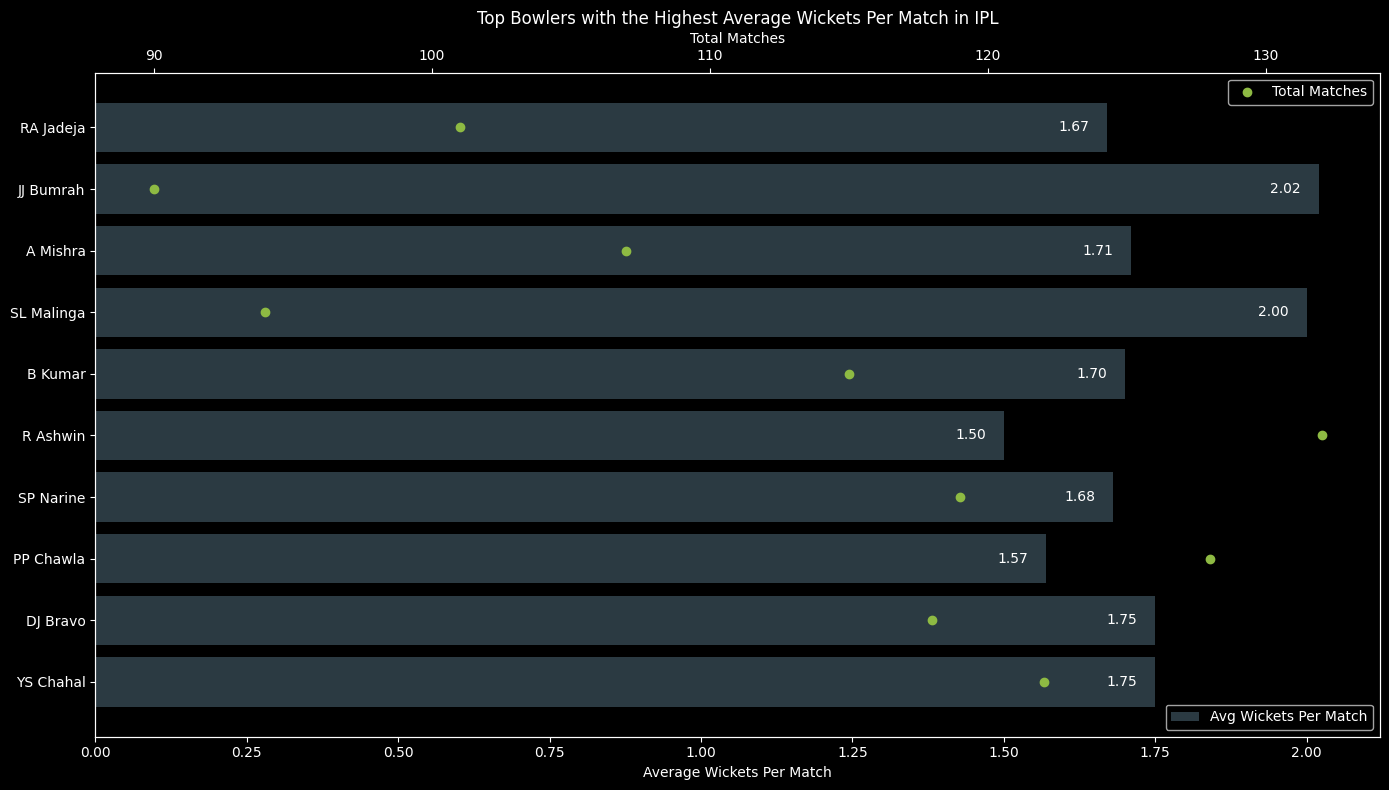

In [434]:
# Convert to Pandas DataFrame
rows = wickets_df.collect()
extras_pd = pd.DataFrame(rows, columns=[col.name for col in wickets_df.schema.fields])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for average extras per match
bars = ax1.barh(extras_pd['bowler'], extras_pd['avg_wickets_per_match'], color=colors['background'], label='Avg Wickets Per Match')
ax1.set_xlabel('Average Wickets Per Match')
ax1.set_title('Top Bowlers with the Highest Average Wickets Per Match in IPL')

# Adding values on the bars
for bar in bars:
    ax1.text(bar.get_width()-0.08, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

# Scatter plot for total matches
ax2 = ax1.twiny()
ax2.scatter(extras_pd['total_matches'], extras_pd['bowler'], color=colors['text'], label='Total Matches')
ax2.set_xlabel('Total Matches')

# Customizing grid and legend
# ax1.grid(True, axis='x')
ax2.grid(False)
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

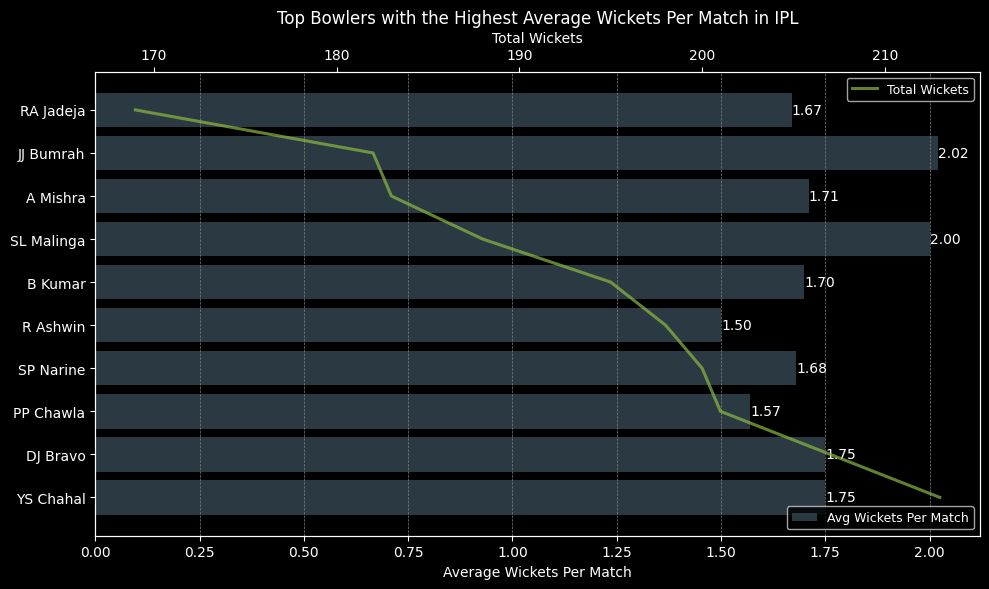

In [451]:
import matplotlib.pyplot as plt

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for average wickets per match
bars = ax1.barh(extras_pd['bowler'], extras_pd['avg_wickets_per_match'], color=colors['background'], label='Avg Wickets Per Match')
ax1.set_xlabel('Average Wickets Per Match', fontsize=10)
ax1.set_title('Top Bowlers with the Highest Average Wickets Per Match in IPL', fontsize=12)

# Adding values on the bars
for bar in bars:
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center', fontsize=10)

# Scatter plot for total wickets
ax2 = ax1.twiny()
ax2.plot(extras_pd['wickets'], extras_pd['bowler'], color=colors['text'], label='Total Wickets', alpha=0.7, linewidth=2.2)
ax2.set_xlabel('Total Wickets', fontsize=10)

# Customizing grid and legend
ax1.grid(True, axis='x', color='gray', linestyle='--', linewidth=0.5)
ax2.grid(False)
ax1.legend(loc='lower right', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


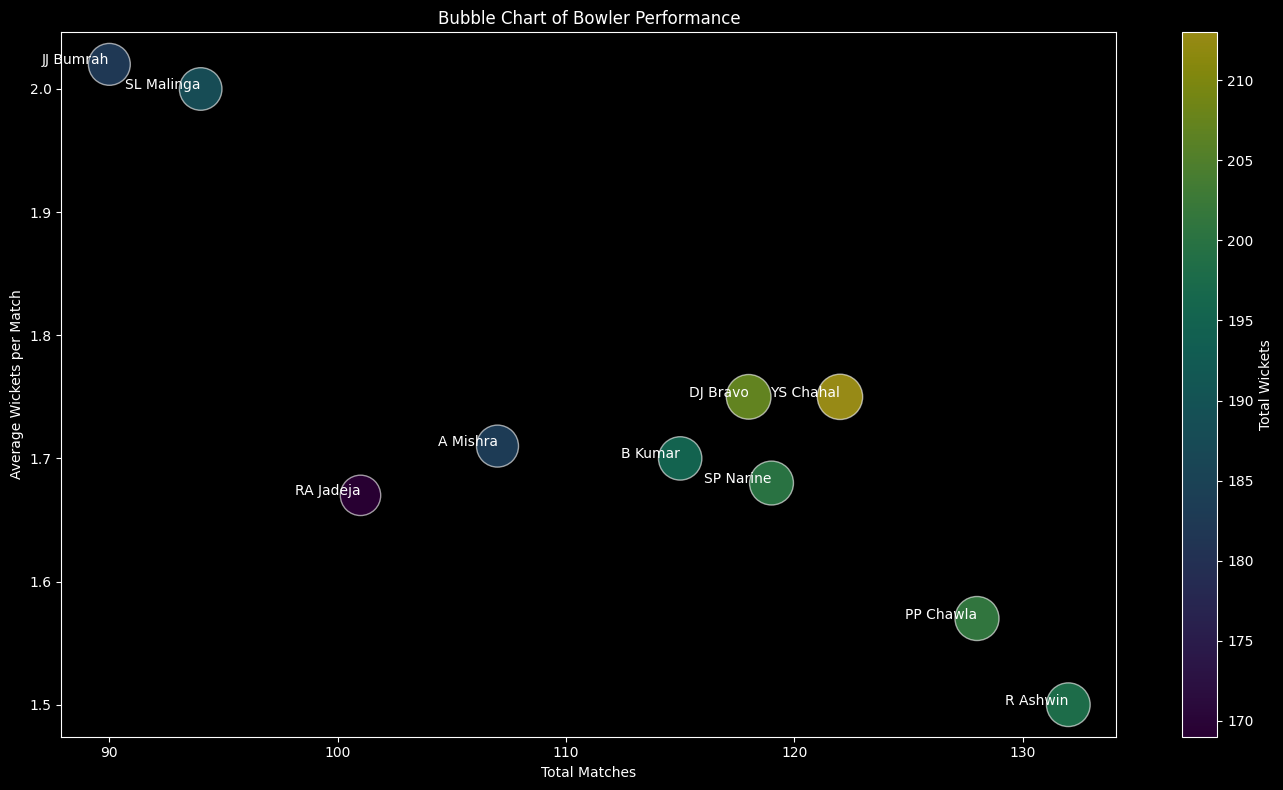

In [179]:
import matplotlib.pyplot as plt

# Data
total_matches = df['Total Matches']
total_wickets = df['Total Wickets']
avg_wickets = df['Average Wickets per Match']
sizes = total_wickets * 5  # Scale size for better visualization

plt.figure(figsize=(14, 8))
scatter = plt.scatter(total_matches, avg_wickets, s=sizes, alpha=0.6, edgecolors="w", c=total_wickets, cmap='viridis')

# Adding labels
for i in range(len(df)):
    plt.text(total_matches[i], avg_wickets[i], df['Bowler'][i], fontsize=10, ha='right')

plt.colorbar(scatter, label='Total Wickets')
plt.xlabel('Total Matches')
plt.ylabel('Average Wickets per Match')
plt.title('Bubble Chart of Bowler Performance')
plt.tight_layout()
plt.show()


- Lasith Malinga and Jasprit Bumrah are standout bowlers with the highest average wickets per match, each taking approximately 2 wickets per game.
- Yuzvendra Chahal and Dwayne Bravo lead in total wickets, demonstrating their consistent performance over many matches.

## 8. Relationship Between Dismissal Type and the Average Over in Which It Occurs

In [196]:
dismissal_kind_df = deliveries.groupBy('dismissal_kind')\
    .agg(round(avg('over'),2).alias('avg_over'))\
    .orderBy('avg_over').show(truncate = False)

+---------------------+--------+
|dismissal_kind       |avg_over|
+---------------------+--------+
|retired hurt         |9.0     |
|NA                   |9.1     |
|lbw                  |9.11    |
|stumped              |10.67   |
|bowled               |10.84   |
|caught               |10.97   |
|caught and bowled    |11.03   |
|hit wicket           |12.93   |
|run out              |13.06   |
|retired out          |16.67   |
|obstructing the field|17.0    |
+---------------------+--------+



- Late Dismissals: Dismissals like 'obstructing the field' and 'retired out' tend to occur later in the game, around overs 17 and 16 respectively, indicating these events might be more common in the final stages of the match.
- Early Dismissals: 'Retired hurt' and 'NA' occur earlier, around overs 9 and 9.1, which could suggest these are more frequent in the middle stages of the innings.
- Typical Dismissals: Common dismissals like 'caught', 'bowled', and 'lbw' happen in the middle overs (around overs 10 to 11), which might be indicative of regular play or typical batting collapses.

In [237]:
deliveries.count()

260920

In [255]:
match_type_df = matches.withColumnRenamed('id','match_id').select('match_id','match_type')
dismissal_df = deliveries.filter(col('dismissal_kind')!='NA')\
                .join(match_type_df, on='match_id',how='inner')
dismissal_df.show(3)

+--------+------+--------------------+--------------------+----+----+----------+---------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+---------+----------+
|match_id|inning|        batting_team|        bowling_team|over|ball|    batter|   bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|  fielder|match_type|
+--------+------+--------------------+--------------------+----+----+----------+---------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+---------+----------+
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   5|   2|SC Ganguly|   Z Khan|BB McCullum|           0|         0|         0|       NULL|        1|      SC Ganguly|        caught|JH Kallis|    League|
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|  12|   1|RT Ponting|JH Kallis|BB McCullum|           0|         0|         0|       NULL

In [283]:
# Define window specification
windowSpec = Window.partitionBy('match_type')

# Calculate total count and normalized count using window function
dismissal_kind_df = dismissal_df.groupBy('dismissal_kind', 'match_type')\
    .agg(round(avg('over'), 2).alias('avg_over'),
         count('*').alias('count'))\
    .filter(col('count') > 10)\
    .withColumn('total_count', count('*').over(windowSpec))\
    .withColumn('count', round(col('count') / col('total_count'),2))\
    .drop('total_count')\
    .orderBy('match_type', 'avg_over')

# Show the result
dismissal_kind_df.show(52, truncate=False)

+-----------------+-----------------+--------+------+
|dismissal_kind   |match_type       |avg_over|count |
+-----------------+-----------------+--------+------+
|caught           |Elimination Final|11.23   |26.0  |
|caught           |Eliminator       |11.09   |30.67 |
|bowled           |Eliminator       |12.11   |6.33  |
|run out          |Eliminator       |13.83   |4.0   |
|bowled           |Final            |8.71    |7.0   |
|lbw              |Final            |11.82   |4.25  |
|caught           |Final            |12.22   |32.5  |
|run out          |Final            |14.36   |5.5   |
|retired hurt     |League           |9.0     |1.88  |
|lbw              |League           |9.1     |92.63 |
|stumped          |League           |10.7    |41.5  |
|bowled           |League           |10.84   |259.5 |
|caught           |League           |10.97   |939.75|
|caught and bowled|League           |11.13   |42.0  |
|hit wicket       |League           |12.93   |1.88  |
|run out          |League   

In [287]:
# ANything to do with Match_type?

dismissal_kind_df = dismissal_df.groupBy('dismissal_kind','match_type')\
    .agg(round(avg('over'),2).alias('avg_over'),
        count('*').alias('count'))\
        .filter(col('count')>10)\
    .orderBy('match_type','avg_over')

dismissal_kind_df.show(52,truncate = False)

+-----------------+-----------------+--------+-----+
|dismissal_kind   |match_type       |avg_over|count|
+-----------------+-----------------+--------+-----+
|caught           |Elimination Final|11.23   |26   |
|caught           |Eliminator       |11.09   |92   |
|bowled           |Eliminator       |12.11   |19   |
|run out          |Eliminator       |13.83   |12   |
|bowled           |Final            |8.71    |28   |
|lbw              |Final            |11.82   |17   |
|caught           |Final            |12.22   |130  |
|run out          |Final            |14.36   |22   |
|retired hurt     |League           |9.0     |15   |
|lbw              |League           |9.1     |741  |
|stumped          |League           |10.7    |332  |
|bowled           |League           |10.84   |2076 |
|caught           |League           |10.97   |7518 |
|caught and bowled|League           |11.13   |336  |
|hit wicket       |League           |12.93   |15   |
|run out          |League           |12.99   |

In [453]:
# Get counts of dismissal types for each match type
dismissal_kind_df = dismissal_df.groupBy('dismissal_kind','match_type')\
    .agg(round(avg('over'),2).alias('avg_over'),
        count('*').alias('count'))\
        .filter(col('count')>10)

# Get total counts of match types across all matches 
all_match_count = matches.groupBy(col('match_type')).agg(count('*').alias('total_count'))
# all_match_count.show()

# Join and normalize the count column
dismissal_kind_df = dismissal_kind_df.join(all_match_count, 'match_type', 'inner')\
    .withColumn('normalized_count', round(col('count') / col('total_count'),2))\
    .drop('total_count')\
    .orderBy('match_type','avg_over')

dismissal_kind_df.show(26,truncate=False)
# dismissal_kind_df.count()

+-----------------+-----------------+--------+-----+----------------+
|match_type       |dismissal_kind   |avg_over|count|normalized_count|
+-----------------+-----------------+--------+-----+----------------+
|Elimination Final|caught           |11.23   |26   |8.67            |
|Eliminator       |caught           |11.09   |92   |8.36            |
|Eliminator       |bowled           |12.11   |19   |1.73            |
|Eliminator       |run out          |13.83   |12   |1.09            |
|Final            |bowled           |8.71    |28   |1.65            |
|Final            |lbw              |11.82   |17   |1.0             |
|Final            |caught           |12.22   |130  |7.65            |
|Final            |run out          |14.36   |22   |1.29            |
|League           |retired hurt     |9.0     |15   |0.01            |
|League           |lbw              |9.1     |741  |0.72            |
|League           |stumped          |10.7    |332  |0.32            |
|League           |b

In [454]:
# Collect data into a list of rows
rows = dismissal_kind_df.collect()

# Convert to Pandas DataFrame
dismissal_pd = pd.DataFrame(rows, columns=[col.name for col in dismissal_kind_df.schema.fields])


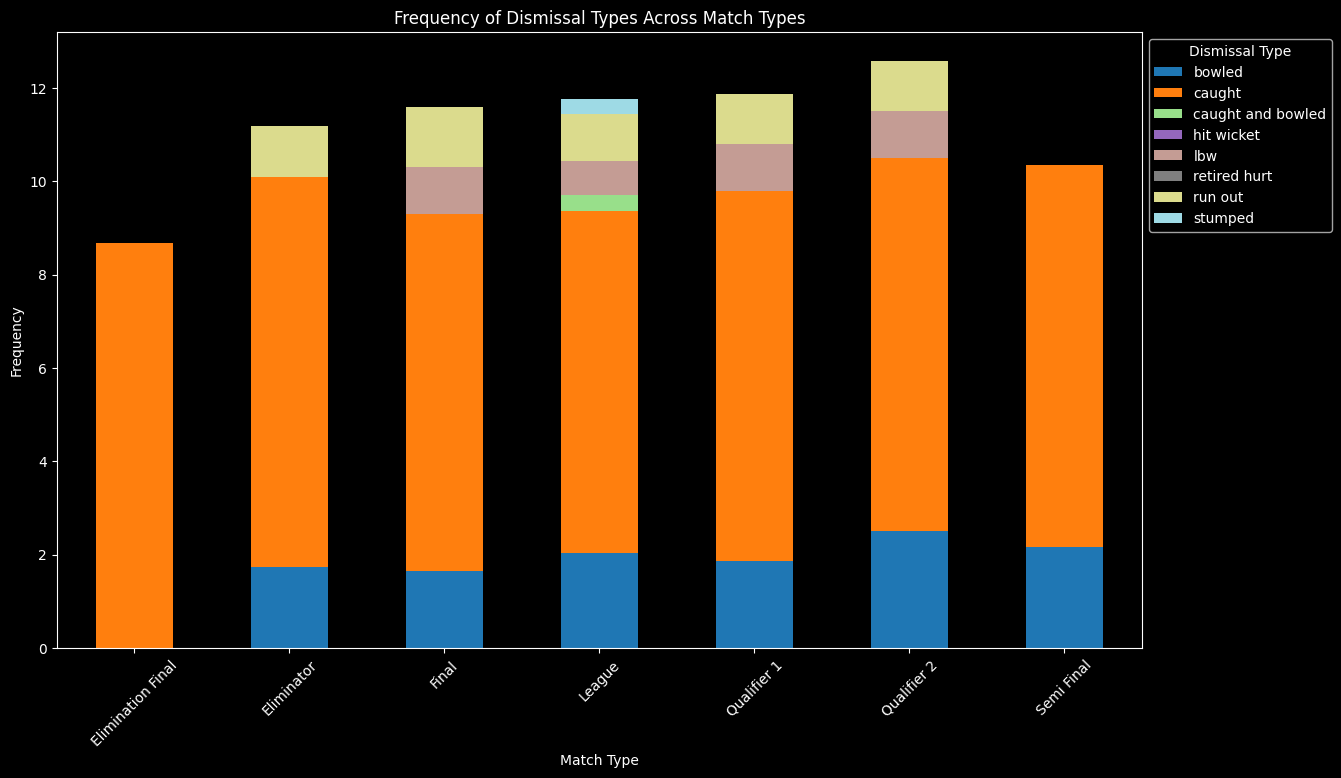

In [459]:
# Pivot data for the stacked bar chart
pivot_df = dismissal_pd.pivot_table(index='match_type', columns='dismissal_kind', values='normalized_count', aggfunc='sum').fillna(0)

# Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Frequency of Dismissal Types Across Match Types')
plt.xlabel('Match Type')
plt.ylabel('Frequency')
plt.legend(title='Dismissal Type', bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


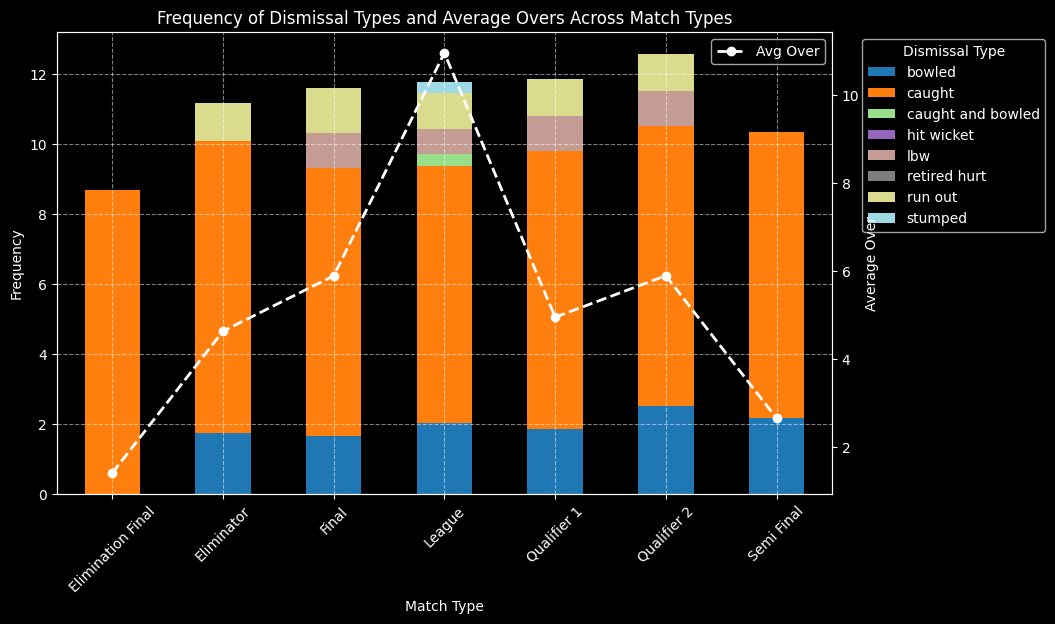

In [464]:
# 
avg_over_df = dismissal_pd.pivot_table(index='match_type', columns='dismissal_kind', values='avg_over', aggfunc='mean').fillna(0)

# Plot stacked bar chart for normalized counts
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for normalized counts
pivot_df.plot(kind='bar', stacked=True, ax=ax1, colormap='tab20', alpha=1)
ax1.set_title('Frequency of Dismissal Types and Average Overs Across Match Types')
ax1.set_xlabel('Match Type')
ax1.set_ylabel('Frequency')
ax1.legend(title='Dismissal Type', bbox_to_anchor=(1.03, 1), loc='upper left')
ax1.set_xticks(range(len(pivot_df.index)))
ax1.set_xticklabels(pivot_df.index, rotation=45)

# Create a second y-axis for the average overs
ax2 = ax1.twinx()
ax2.plot(avg_over_df.index, avg_over_df.mean(axis=1), color='white', marker='o', linestyle='--', linewidth=2, label='Avg Over')
ax2.set_ylabel('Average Over', color='white')
ax2.tick_params(axis='y', labelcolor='white')

# Add gridlines and legends
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.legend(loc='upper right')

plt.show()


1. Frequency of Dismissals Across Match Types
High Frequency of "Caught": The caught dismissal type is predominant across all match types, especially in league matches. This is consistent with the high count and frequency shown in the stacked bar chart.
Less Frequent Dismissals: Types like hit wicket and retired hurt are very rare, with very few occurrences across all match types. This aligns with their lower counts in the data.
2. Average Over for Dismissals
Early Dismissals in Finals and Qualifiers: The line plot indicates that dismissals generally occur earlier in finals and qualifiers. For example, dismissals in the Final happen around the 8th to 12th over, suggesting that matches tend to have significant turning points early on.
Later Dismissals in League Matches: In league matches, dismissals occur slightly later on average, around the 10th to 11th over. This could imply that league matches might have a more gradual progression with fewer early breakthroughs compared to knockout stages.
3. Comparison Between Match Types
Finals and Eliminators: The average overs for dismissals are lower in finals and eliminators compared to league matches. This could indicate increased pressure in these high-stakes games leading to earlier dismissals or tighter bowling strategies.
League Matches: The average over for dismissals in league matches is slightly higher, suggesting a more balanced and possibly less intense game flow, where wickets fall more evenly throughout the innings.
4. Impact of Match Type on Dismissal Patterns
Pressure Situations: The pattern of dismissals in high-pressure games (finals, eliminators) happening earlier in the innings can be interpreted as a result of more aggressive play or high-pressure situations leading to earlier wickets.
Stable Performance in League Matches: League matches show a more stable and evenly distributed pattern of dismissals, reflecting a less variable but consistent performance throughout the match.
Summary
Early Wickets: High-stakes matches like finals and eliminators see earlier dismissals, reflecting the intensity and pressure of these games.
Consistent Performance in League Matches: League matches tend to have more consistent and later dismissals, which may indicate a steadier game progression without the same level of early aggression.

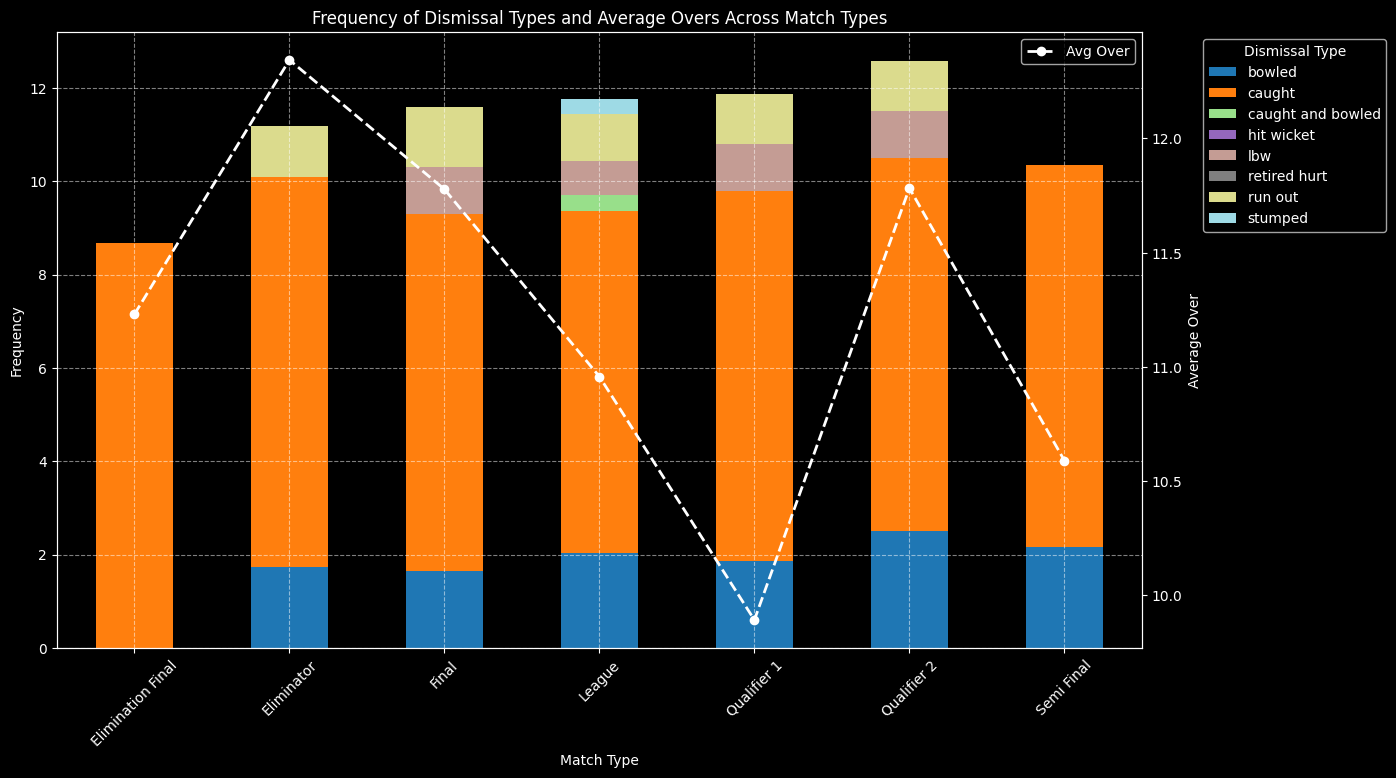

In [457]:

# Compute the average over per match type
avg_over_per_match_type = dismissal_pd.groupby('match_type')['avg_over'].mean().reset_index()
avg_over_per_match_type.rename(columns={'avg_over': 'avg_over_per_match_type'}, inplace=True)

# Merge with the original DataFrame to include average over in the plot
dismissal_pd = dismissal_pd.merge(avg_over_per_match_type, on='match_type')


# Pivot table for normalized counts
pivot_df = dismissal_pd.pivot_table(index='match_type', columns='dismissal_kind', values='normalized_count', aggfunc='sum').fillna(0)

# Pivot table for average overs
avg_over_df = dismissal_pd.pivot_table(index='match_type', values='avg_over_per_match_type', aggfunc='mean').fillna(0)

# Create a plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Stacked bar chart for normalized counts
pivot_df.plot(kind='bar', stacked=True, ax=ax1, colormap='tab20', alpha=1)
ax1.set_title('Frequency of Dismissal Types and Average Overs Across Match Types')
ax1.set_xlabel('Match Type')
ax1.set_ylabel('Frequency')
ax1.legend(title='Dismissal Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticks(range(len(pivot_df.index)))
ax1.set_xticklabels(pivot_df.index, rotation=45)

# Create a secondary y-axis for average overs
ax2 = ax1.twinx()
ax2.plot(avg_over_df.index, avg_over_df['avg_over_per_match_type'], color='white', marker='o', linestyle='--', linewidth=2, label='Avg Over')
ax2.set_ylabel('Average Over', color='white')
ax2.tick_params(axis='y', labelcolor='white')

# Add gridlines and legends
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.legend(loc='upper right')

plt.show()

Y-Axis (Average Over): This is a secondary axis that shows the average over where dismissals occur for each match type.

Line Plot: The line with markers shows the average over for each match type. This tells you on average at which over dismissals occur, considering all types of dismissals combined.

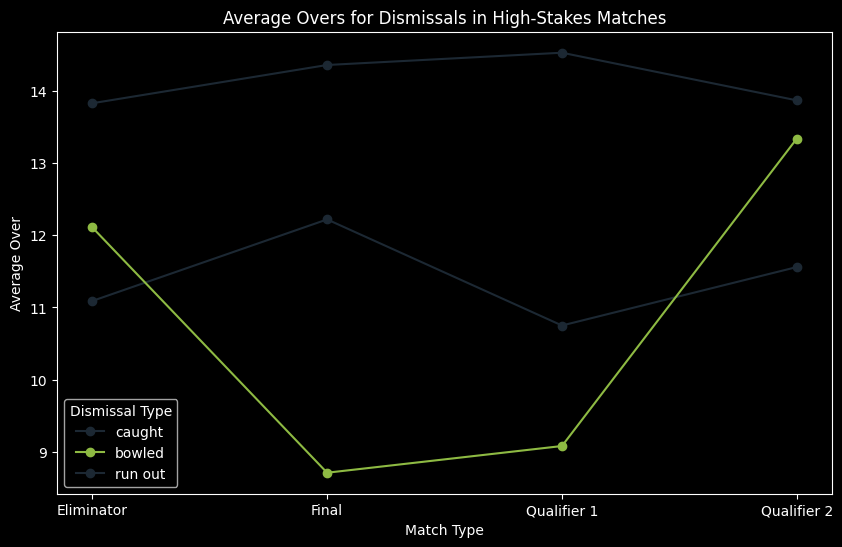

In [269]:
import matplotlib.pyplot as plt

# Example DataFrame for the line chart
data = {
    'match_type': ['Eliminator', 'Final', 'Qualifier 1', 'Qualifier 2'],
    'caught': [11.09, 12.22, 10.75, 11.56],
    'bowled': [12.11, 8.71, 9.08, 13.34],
    'run out': [13.83, 14.36, 14.53, 13.87]
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
for dismissal in ['caught', 'bowled', 'run out']:
    plt.plot(df['match_type'], df[dismissal], marker='o', label=dismissal)

plt.title('Average Overs for Dismissals in High-Stakes Matches')
plt.xlabel('Match Type')
plt.ylabel('Average Over')
plt.legend(title='Dismissal Type')
plt.show()


## 9. Most catches caught by feilder?

In [212]:
fielder_df = deliveries.filter(col('dismissal_kind')=='caught')\
    .groupBy('fielder')\
    .agg(count('*').alias('total_catches'),
         F.countDistinct('match_id').alias('total_matches_played'))\
    .withColumn('avg_catches',round(col('total_catches')/col('total_matches_played'),2))\
    .orderBy(desc('total_catches'), desc('avg_catches'))\
     .limit(10).show(truncate=False)

+--------------+-------------+--------------------+-----------+
|fielder       |total_catches|total_matches_played|avg_catches|
+--------------+-------------+--------------------+-----------+
|MS Dhoni      |152          |110                 |1.38       |
|KD Karthik    |145          |110                 |1.32       |
|AB de Villiers|120          |87                  |1.38       |
|V Kohli       |114          |94                  |1.21       |
|SK Raina      |106          |80                  |1.33       |
|RG Sharma     |100          |84                  |1.19       |
|S Dhawan      |100          |85                  |1.18       |
|KA Pollard    |97           |76                  |1.28       |
|RA Jadeja     |97           |76                  |1.28       |
|WP Saha       |93           |69                  |1.35       |
+--------------+-------------+--------------------+-----------+



In [216]:
# Filter and aggregate data
fielder_df = (
    deliveries
    .filter(F.col('dismissal_kind') == 'caught')
    .groupBy('fielder')
    .agg(
        F.count('*').alias('total_catches'),
        F.countDistinct('match_id').alias('total_matches_played')
    )
    .withColumn('avg_catches', F.round(F.col('total_catches') / F.col('total_matches_played'), 2))
    .orderBy(F.desc('total_catches'), F.desc('avg_catches')).limit(10)
)

fielder_df.show(truncate=False)

+--------------+-------------+--------------------+-----------+
|fielder       |total_catches|total_matches_played|avg_catches|
+--------------+-------------+--------------------+-----------+
|MS Dhoni      |152          |110                 |1.38       |
|KD Karthik    |145          |110                 |1.32       |
|AB de Villiers|120          |87                  |1.38       |
|V Kohli       |114          |94                  |1.21       |
|SK Raina      |106          |80                  |1.33       |
|RG Sharma     |100          |84                  |1.19       |
|S Dhawan      |100          |85                  |1.18       |
|KA Pollard    |97           |76                  |1.28       |
|RA Jadeja     |97           |76                  |1.28       |
|WP Saha       |93           |69                  |1.35       |
+--------------+-------------+--------------------+-----------+



- Top Performers: MS Dhoni and KD Karthik are the top two fielders with the most catches, both having 145 and 152 catches respectively. They are closely followed by AB de Villiers and V Kohli.
- Consistency vs. Quantity: Despite MS Dhoni and KD Karthik having the highest total catches, their average catches per match are slightly lower compared to AB de Villiers. This suggests that while they have a high volume of catches, they might have played more matches.
- Efficiency: AB de Villiers and WP Saha have high averages for catches per match, indicating efficiency in catching. They might have had fewer matches but were very effective when they played.